# 회귀분석의 결과 보고 (sklearn)

## #01. 준비작업

### [1] 패키지 참조

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame
from tabulate import tabulate

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 성능 평가 지표 모듈
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import t, f
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

### [2] 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.unicode_minus"] = False

### [3] 데이터 가져오기

In [3]:
origin = read_excel("https://data.hossam.kr/mldata/fish.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #02. 데이터 전처리

### [1] 독립변수(들)의 이름과 종속변수의 이름을 변수에 저장

In [4]:
yname = '무게'
xnames = list(origin.drop(yname, axis=1).columns)

### [2] 독립변수와 종속변수 분리

이전 예제와 동일한 결과를 만들기 위해 훈련/검증 데이터의 분할은 수행하지 않음

In [5]:
x_train = origin[xnames]   # 독립변수는 데이터 프레임 형태로 분리
y_train = origin[yname]    # 종속변수는 시리즈 형태로 분리

## #03. 회귀분석

훈련/검증 데이터를 나누지 않았으므로 검증데이터에 대한 설명력은 얻을 수 없다.

무게 = 2.908 * 길이 + 67.205 * 높이 + 67.260 * 두께 + -546.440
+-------------------------------+--------------+
|                               |   훈련데이터 |
|-------------------------------+--------------|
| 결정계수(R2)                  |     0.942303 |
| 평균절대오차(MAE)             |      62.5758 |
| 평균제곱오차(MSE)             |      6847.54 |
| 평균오차(RMSE)                |      82.7499 |
| 평균 절대 백분오차 비율(MAPE) |      124.554 |
| 평균 비율 오차(MPE)           |      97.1079 |
+-------------------------------+--------------+



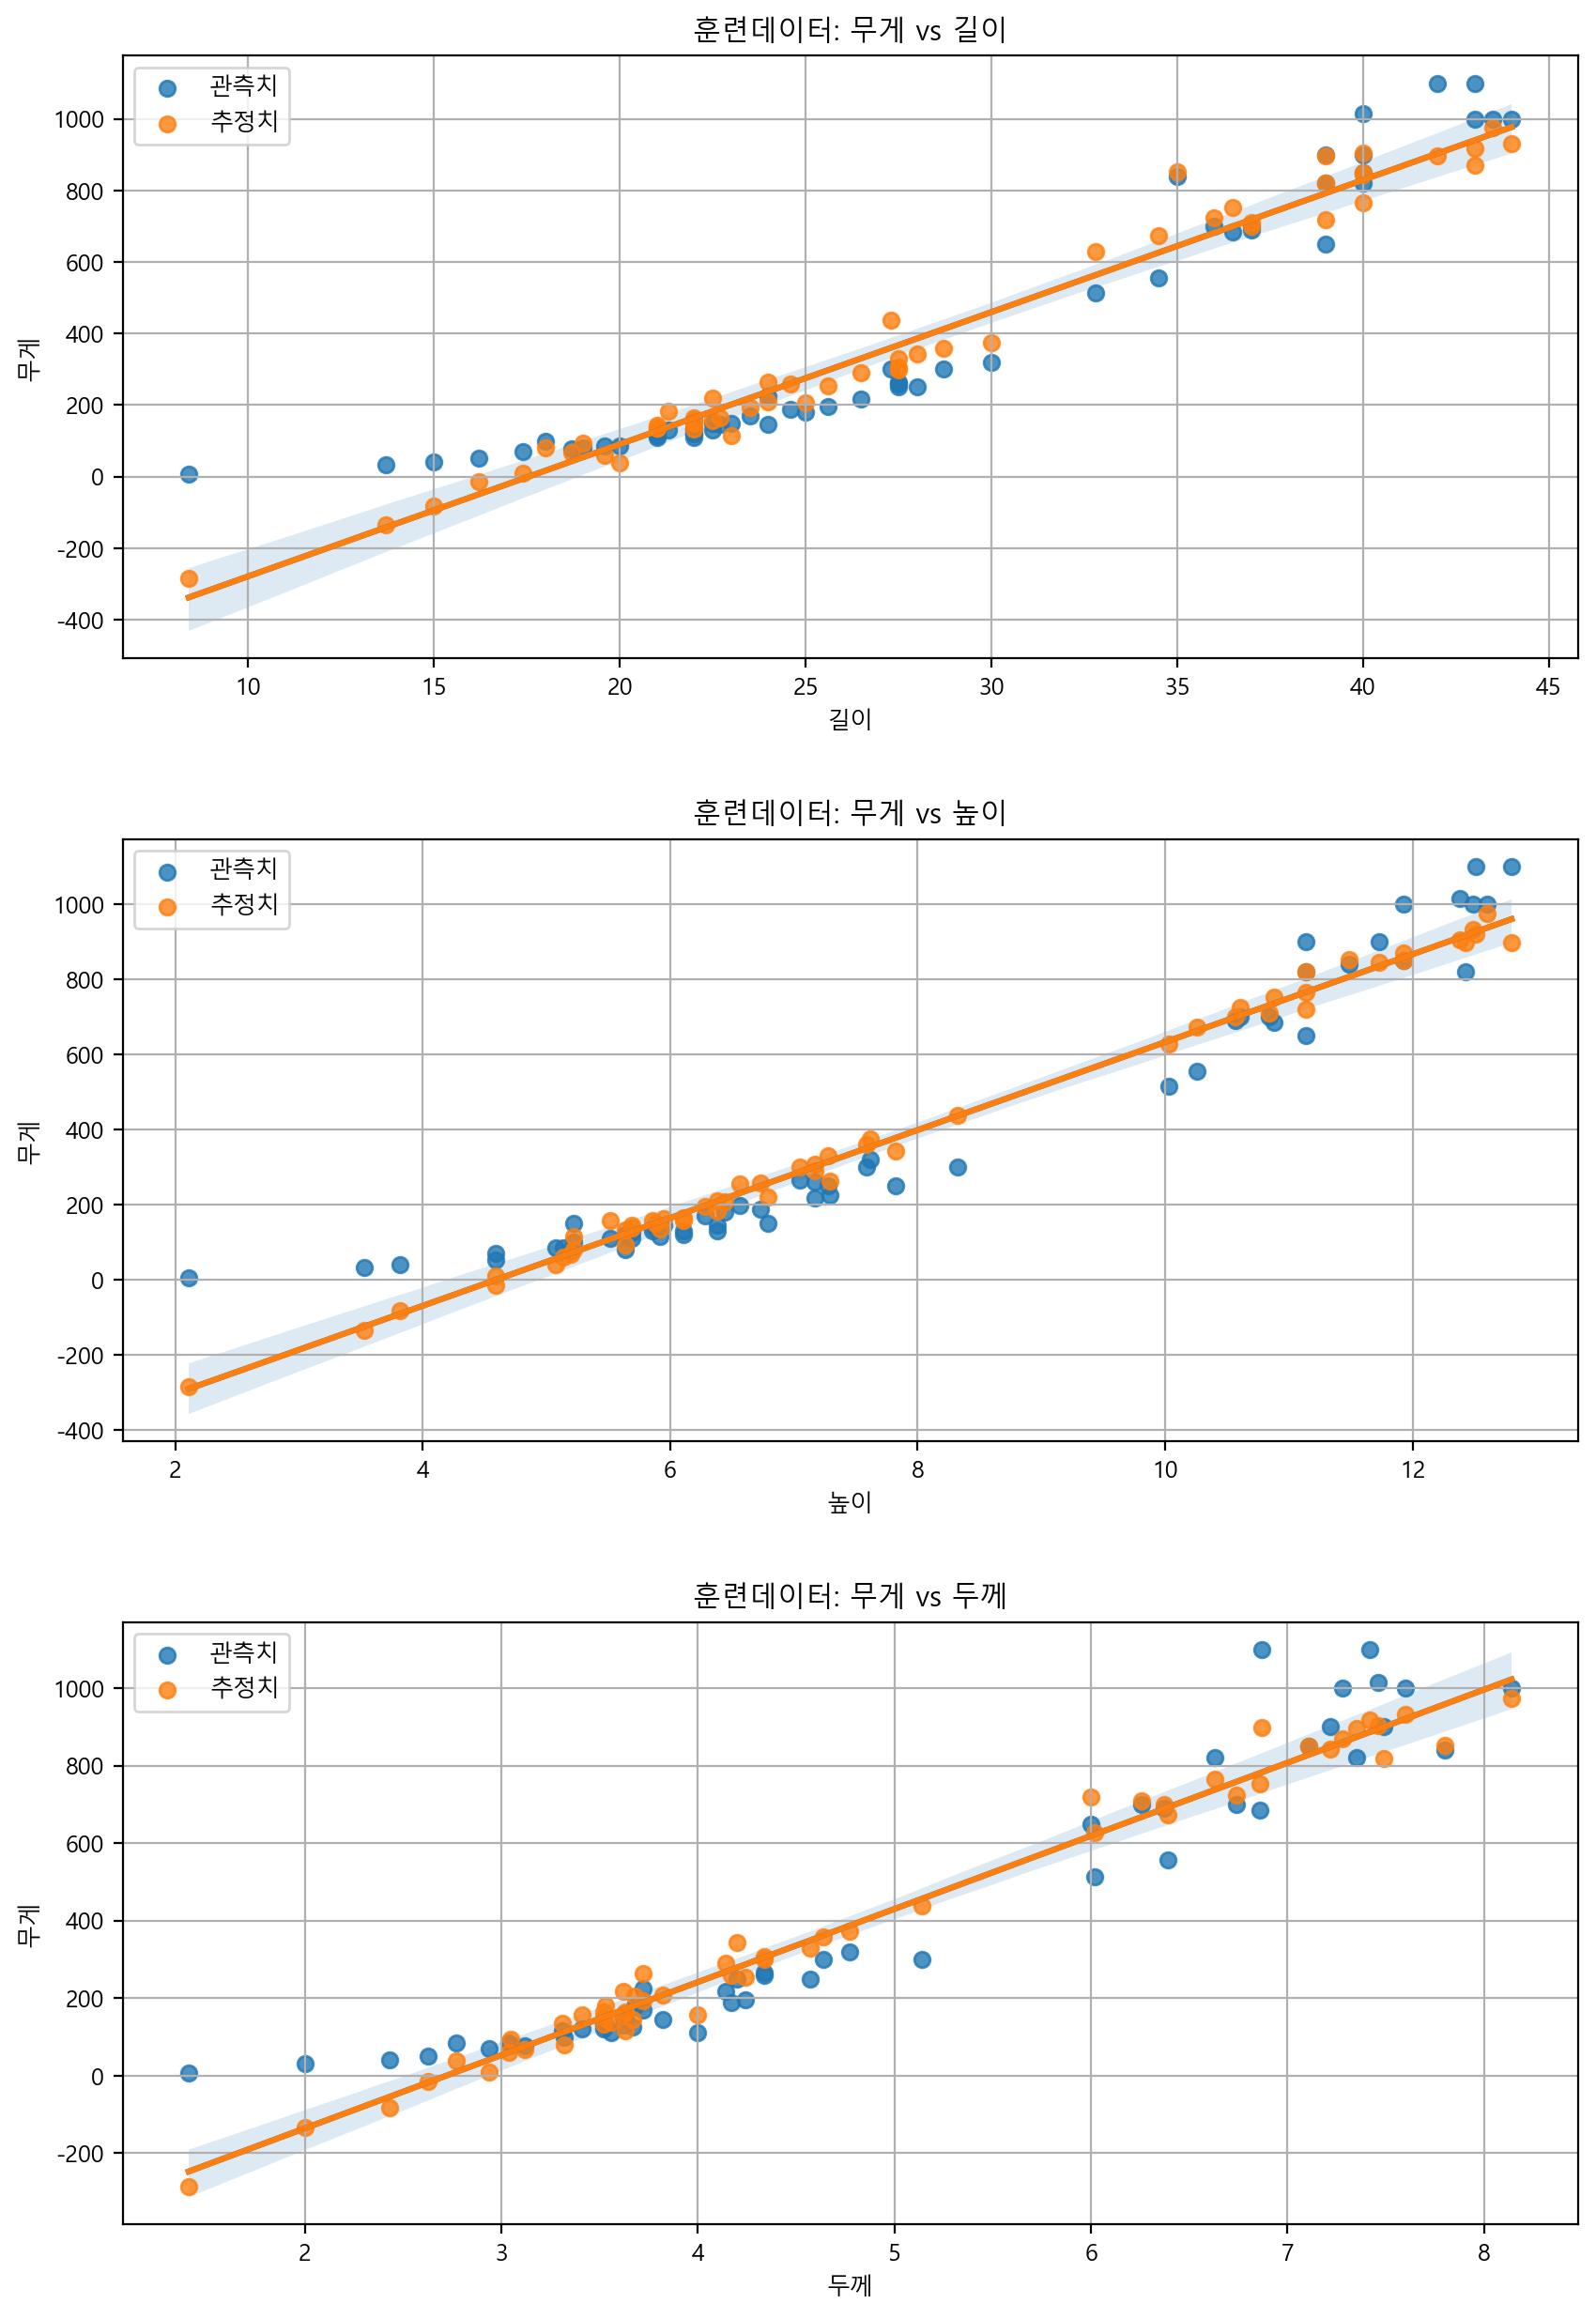

In [6]:
size = len(xnames)

# 분석모델 생성
model = LinearRegression(n_jobs=-1)
fit = model.fit(x_train, y_train)

# 회귀식
expr = "{yname} = ".format(yname=yname)

for i, v in enumerate(xnames):
    expr += "%0.3f * %s + " % (fit.coef_[i], v)

expr += "%0.3f" % fit.intercept_
print(expr)

# 추정치 생성
y_train_pred = fit.predict(x_train)
#y_test_pred = fit.predict(x_test)

# 성능평가
result1 = {
    "결정계수(R2)": r2_score(y_train, y_train_pred),
    "평균절대오차(MAE)": mean_absolute_error(y_train, y_train_pred),
    "평균제곱오차(MSE)": mean_squared_error(y_train, y_train_pred),
    "평균오차(RMSE)": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "평균 절대 백분오차 비율(MAPE)": np.mean(np.abs((y_train - y_train_pred) / y_train) * 100),
    "평균 비율 오차(MPE)": np.mean((y_train - y_train_pred) / y_train * 100)
}

# result2 = {
#     "결정계수(R2)": r2_score(y_test, y_test_pred),
#     "평균절대오차(MAE)": mean_absolute_error(y_test, y_test_pred),
#     "평균제곱오차(MSE)": mean_squared_error(y_test, y_test_pred),
#     "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_test_pred)),
#     "평균 절대 백분오차 비율(MAPE)": np.mean(np.abs((y_test - y_test_pred) / y_test) * 100),
#     "평균 비율 오차(MPE)": np.mean((y_test - y_test_pred) / y_test * 100)
# }

#result_df = DataFrame([result1, result2], index=["훈련데이터", "검증데이터"])
result_df = DataFrame([result1], index=["훈련데이터"])
print(tabulate(result_df.T, headers='keys', tablefmt='psql', showindex=True, numalign="right"), end="\n\n")

# 시각화
#fig, ax = plt.subplots(len(xnames), 2, figsize=(20, 5*size), dpi=200)
fig, ax = plt.subplots(len(xnames), 1, figsize=(10, 5*size), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(xnames):
    # sb.regplot(x=x_train[v], y=y_train, ci=95, ax=ax[i][0], label='관측치')
    # sb.regplot(x=x_train[v], y=y_train_pred, ci=0, ax=ax[i][0], label='추정치')
    sb.regplot(x=x_train[v], y=y_train, ci=95, ax=ax[i], label='관측치')
    sb.regplot(x=x_train[v], y=y_train_pred, ci=0, ax=ax[i], label='추정치')

    # ax[i][0].set_title(f"훈련데이터: {yname} vs {v}")
    # ax[i][0].legend()
    # ax[i][0].grid(True)
    ax[i].set_title(f"훈련데이터: {yname} vs {v}")
    ax[i].legend()
    ax[i].grid(True)

    # sb.regplot(x=x_test[v], y=y_test, ci=95, ax=ax[i][1], label='관측치')
    # sb.regplot(x=x_test[v], y=y_test_pred, ci=0, ax=ax[i][1], label='추정치')
    # ax[i][1].set_title(f"검증데이터: {yname} vs {v}")
    # ax[i][1].legend()
    # ax[i][1].grid(True)

plt.show()
plt.close()

## #04. 결과보고

### [1] 독립변수에 대한 통계량과 p-value

#### (1) 절편과 계수를 하나의 배열로 결합

In [7]:
params = np.append(fit.intercept_, fit.coef_)
params

array([-546.43979144,    2.9082713 ,   67.20469902,   67.26029602])

#### (2) 독립변수에 상수항 추가하기

In [8]:
design_x = x_train.copy()

# 0번째 필드에 '상수'라는 이름의 컬럼을 추가하고 값은 1로 설정함
design_x.insert(0, '상수', 1)

design_x.head()

,상수,길이,높이,두께
0,1,8.4,2.11,1.41
1,1,13.7,3.53,2.00
2,1,15.0,3.82,2.43
3,1,16.2,4.59,2.63
4,1,17.4,4.59,2.94


#### (3) 행렬곱 구하기

In [9]:
dot = np.dot(design_x.T,design_x)
dot

array([[   56.    ,  1562.    ,   440.28  ,   265.75  ],
       [ 1562.    , 48045.12  , 13688.339 ,  8270.876 ],
       [  440.28  , 13688.339 ,  3917.2114,  2365.5425],
       [  265.75  ,  8270.876 ,  2365.5425,  1434.4117]])

#### (4) 행렬곱의 역행렬

In [10]:
inv = np.linalg.inv(dot)
inv

array([[ 0.25997581, -0.02937614,  0.05587393,  0.02907514],
       [-0.02937614,  0.00811062, -0.0207489 , -0.00710593],
       [ 0.05587393, -0.0207489 ,  0.11758923, -0.08463348],
       [ 0.02907514, -0.00710593, -0.08463348,  0.17585582]])

#### (5) 역행렬의 대각선 반환

In [11]:
dia = inv.diagonal()
dia

array([0.25997581, 0.00811062, 0.11758923, 0.17585582])

#### (6) 평균 제곱오차 구하기

sklearn의 API는 상수항이 고려되지 않은 MSE 구한다.

상수항이 적용된 경우이므로 API를 통한 값이 아닌 직접 구한 값이 필요하다

In [12]:
predictions = fit.predict(x_train)
MSE = (sum((y_train-predictions)**2)) / (len(design_x)-len(design_x.iloc[0]))
MSE

7374.273394715796

#### (7) 표준오차

In [13]:
se_b = np.sqrt(MSE * dia)
se_b

array([43.78507388,  7.73368804, 29.44715768, 36.0112326 ])

#### (8) t-value 구하기

In [14]:
ts_b = params / se_b
ts_b

array([-12.48004726,   0.37605232,   2.28221344,   1.86775878])

#### (9) p-value 구하기

In [15]:
p_values = [2*(1-t.cdf(np.abs(i),(len(design_x)-len(design_x.iloc[0])))) for i in ts_b]
p_values

[0.0, 0.7084079152880327, 0.02659771778769593, 0.06743585337093783]

### [2] VIF 구하기

In [16]:
vif = []

for i, v in enumerate(xnames):
    j = list(x_train.columns).index(v)
    vif.append(variance_inflation_factor(x_train, j))

print(vif)

[230.19583296880919, 413.5823816399529, 247.58536118612028]


### [3] 표준화 계수(베타) 구하기

독립변수와 종속변수를 표준화 한 후 머신러닝을 수행한 경우에 대한 계수값

In [17]:
scaler = StandardScaler()
std = scaler.fit_transform(origin)
std_df = DataFrame(std, columns=origin.columns)
std_df.head()

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,-1.092422
1,-1.587434,-1.518703,-1.560774,-1.016660
2,-1.442032,-1.417039,-1.316328,-0.993438
3,-1.307815,-1.147103,-1.202633,-0.960056
4,-1.173599,-1.147103,-1.026405,-0.906355


In [18]:
std_x = std_df[xnames]
std_y = std_df[yname]
std_model = LinearRegression(n_jobs=-1)
std_fit = std_model.fit(std_x, std_y)
beta = std_fit.coef_
beta

array([0.07547791, 0.55646807, 0.34344464])

### [4] 결과표 구성하기

In [19]:
result_df = DataFrame({
    "종속변수": [yname] * len(xnames),
    "독립변수": xnames,
    "B(비표준화 계수)": np.round(params[1:], 4),
    "표준오차": np.round(se_b[1:], 3),
    "β(표준화 계수)": np.round(beta, 4),
    "t": np.round(ts_b[1:], 4),
    "유의확률": np.round(p_values[1:], 3),
    "VIF": vif,
})

result_df

,종속변수,독립변수,B(비표준화 계수),표준오차,β(표준화 계수),t,유의확률,VIF
0,무게,길이,2.9083,7.734,0.0755,0.3761,0.708,230.195833
1,무게,높이,67.2047,29.447,0.5565,2.2822,0.027,413.582382
2,무게,두께,67.2603,36.011,0.3434,1.8678,0.067,247.585361


### [5] 분석 결과 보고

#### (1) 잔차 구하기

$관측치 - 추정치$

In [20]:
y_train_pred = fit.predict(x_train)

# 잔차 계산
resid = y_train - y_train_pred
resid[:5]

0    291.271380
1    166.843295
2    122.651252
3     65.461649
4     59.621032
Name: 무게, dtype: float64

#### (2) durbin_watson 구하기

In [21]:
dw = durbin_watson(resid)
dw

0.4848900475687647

#### (3) 설명력($R^2$)

In [22]:
r2 = r2_score(y_train, y_train_pred)
r2

0.9423026213750791

#### (4) 보정된 $R^2$

In [23]:
# 표본수
rowcount = len(origin)
rowcount

56

In [24]:
# 독립변수의 수
featurecount = len(xnames)
featurecount

3

In [25]:
adj_r2 = 1 - (1 - r2) * (rowcount-1) / (rowcount-featurecount-1)
adj_r2

0.9389739264544106

#### (5) 모델에 대한 F-통계량과 확률 값 계산

In [26]:
# F-statistic
f_statistic = (r2 / featurecount) / ((1 - r2) / (rowcount - featurecount - 1))

# Prob (F-statistic)
p = 1 - f.cdf(f_statistic, featurecount, rowcount - featurecount - 1)

print(f"F-statistic: {f_statistic:.2f}")
print(f"p-value: {p:.4g}")

F-statistic: 283.08
p-value: 1.11e-16


#### (6) 결과보고 문자열

In [27]:
tpl = "𝑅^2(%.3f), Adj.𝑅^2(%.3f), 𝐹(%.3f), P-value(%.4g), Durbin-Watson(%.3f)"
tpl % (r2, adj_r2, f_statistic, p, dw)

'𝑅^2(0.942), Adj.𝑅^2(0.939), 𝐹(283.085), P-value(1.11e-16), Durbin-Watson(0.485)'

In [28]:
tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %0.3f, p %s 0.05)."

tpl % (
    yname,
    ",".join(xnames),
    "유의하다" if p <= 0.05 else "유의하지 않다",
    len(x_train.columns),
    len(x_train.index)-len(x_train.columns)-1,
    f_statistic,
    "<=" if p <= 0.05 else ">")

'무게에 대하여 길이,높이,두께로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,52) = 283.085, p <= 0.05).'

### [6] 독립변수 보고

In [29]:
varstr = []

for n in xnames:
    item = result_df[result_df['독립변수'] == n]
    coef = float(item['B(비표준화 계수)'].values[0])
    pvalue = float(item['유의확률'].values[0])

    s = "%s의 회귀계수는 %0.3f(p %s 0.05)로, %s에 대하여 %s."
    k = s % (n,
             coef,
             "<=" if pvalue <= 0.05 else '>',
             yname,
             '유의미한 예측변인인 것으로 나타났다' if pvalue <= 0.05 else '유의하지 않은 예측변인인 것으로 나타났다'
    )

    varstr.append(k)

varstr

['길이의 회귀계수는 2.908(p > 0.05)로, 무게에 대하여 유의하지 않은 예측변인인 것으로 나타났다.',
 '높이의 회귀계수는 67.205(p <= 0.05)로, 무게에 대하여 유의미한 예측변인인 것으로 나타났다.',
 '두께의 회귀계수는 67.260(p > 0.05)로, 무게에 대하여 유의하지 않은 예측변인인 것으로 나타났다.']

## #05. 결과보고 일괄처리

In [30]:
target_x = x_train.copy()
target_y = y_train.copy()
target_y_pred = fit.predict(target_x)
resid = target_y - target_y_pred

# 절편과 계수를 하나의 배열로 결합
params = np.append(fit.intercept_, fit.coef_)

# 검증용 독립변수에 상수항 추가
design_x = target_x.copy()
design_x.insert(0, '상수', 1)

dot = np.dot(design_x.T,design_x)   # 행렬곱
inv = np.linalg.inv(dot)            # 역행렬
dia = inv.diagonal()                # 대각원소

# 제곱오차
MSE = (sum((target_y-target_y_pred)**2)) / (len(design_x)-len(design_x.iloc[0]))

se_b = np.sqrt(MSE * dia)           # 표준오차
ts_b = params / se_b                # t값

# 각 독립수에 대한 pvalue
p_values = [2*(1-t.cdf(np.abs(i),(len(design_x)-len(design_x.iloc[0])))) for i in ts_b]

# VIF
vif = [variance_inflation_factor(target_x, list(target_x.columns).index(v)) for i, v in enumerate(target_x.columns)]

# 표준화 계수
train_df = target_x.copy()
train_df[target_y.name] = target_y
scaler = StandardScaler()
std = scaler.fit_transform(train_df)
std_df = DataFrame(std, columns=train_df.columns)
std_x = std_df[xnames]
std_y = std_df[yname]
std_model = LinearRegression(n_jobs=-1)
std_fit = std_model.fit(std_x, std_y)
beta = std_fit.coef_

# 결과표 구성하기
result_df = DataFrame({
    "종속변수": [yname] * len(xnames),
    "독립변수": xnames,
    "B(비표준화 계수)": np.round(params[1:], 4),
    "표준오차": np.round(se_b[1:], 3),
    "β(표준화 계수)": np.round(beta, 3),
    "t": np.round(ts_b[1:], 3),
    "유의확률": np.round(p_values[1:], 3),
    "VIF": vif,
})

#result_df
print(tabulate(result_df, headers='keys', tablefmt='psql', showindex=True, numalign="right"), end="\n\n")

resid = target_y - target_y_pred        # 잔차
dw = durbin_watson(resid)               # 더빈 왓슨 통계량
r2 = r2_score(target_y, target_y_pred)  # 결정계수(설명력)
rowcount = len(target_x)                # 표본수
featurecount = len(target_x.columns)    # 독립변수의 수

# 보정된 결정계수
adj_r2 = 1 - (1 - r2) * (rowcount-1) / (rowcount-featurecount-1)

# f값
f_statistic = (r2 / featurecount) / ((1 - r2) / (rowcount - featurecount - 1))

# Prob (F-statistic)
p = 1 - f.cdf(f_statistic, featurecount, rowcount - featurecount - 1)

tpl = "𝑅^2(%.3f), Adj.𝑅^2(%.3f), F(%.3f), P-value(%.4g), Durbin-Watson(%.3f)"
print(tpl % (r2, adj_r2, f_statistic, p, dw), end="\n\n")

# 결과보고
tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %0.3f, p %s 0.05)."

print(tpl % (
    yname,
    ",".join(xnames),
    "유의하다" if p <= 0.05 else "유의하지 않다",
    len(target_x.columns),
    len(target_x.index)-len(target_x.columns)-1,
    f_statistic,
    "<=" if p <= 0.05 else ">"), end="\n\n")

# 독립변수 보고
for n in xnames:
    item = result_df[result_df['독립변수'] == n]
    coef = item['B(비표준화 계수)'].values[0]
    pvalue = item['유의확률'].values[0]

    s = "%s의 회귀계수는 %0.3f(p %s 0.05)로, %s에 대하여 %s."
    k = s % (n,
             coef,
             "<=" if pvalue <= 0.05 else '>',
             yname,
             '유의미한 예측변인인 것으로 나타났다' if pvalue <= 0.05 else '유의하지 않은 예측변인인 것으로 나타났다'
    )

    print(k)

+----+------------+------------+--------------------+------------+------------------+-------+------------+---------+
|    | 종속변수   | 독립변수   |   B(비표준화 계수) |   표준오차 |   β(표준화 계수) |     t |   유의확률 |     VIF |
|----+------------+------------+--------------------+------------+------------------+-------+------------+---------|
|  0 | 무게       | 길이       |             2.9083 |      7.734 |            0.075 | 0.376 |      0.708 | 230.196 |
|  1 | 무게       | 높이       |            67.2047 |     29.447 |            0.556 | 2.282 |      0.027 | 413.582 |
|  2 | 무게       | 두께       |            67.2603 |     36.011 |            0.343 | 1.868 |      0.067 | 247.585 |
+----+------------+------------+--------------------+------------+------------------+-------+------------+---------+

𝑅^2(0.942), Adj.𝑅^2(0.939), F(283.085), P-value(1.11e-16), Durbin-Watson(0.485)

무게에 대하여 길이,높이,두께로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(3,52) = 283.085, p <= 0.05).

길이의 회귀계수는 2.908(p > 0.05)로, 무게에 대하여 유의하지 않은 예측변인인 

## 참고자료(Reference)

1) https://m.blog.naver.com/pmw9440/222482746927

2) https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression

3) https://stats.stackexchange.com/questions/85943/how-to-derive-the-standard-error-of-linear-regression-coefficient

4) https://calcworkshop.com/linear-regression/t-test/

5) https://www.google.com/url?sa=i&url=http%3A%2F%2Fwww.few.vu.nl%2F~wvanwie%2FCourses%2FHighdimensionalDataAnalysis%2FWNvanWieringen_HDDA_Lecture234_RidgeRegression_20182019.pdf&psig=AOvVaw31slQKGfkCNf2PAa3VEIGC&ust=1630070470635000&source=images&cd=vfe&ved=0CAsQjRxqFwoTCIjJworkzvICFQAAAAAdAAAAABAR